In [1]:
# Install MedViT
!git clone https://github.com/Omid-Nejati/MedViT.git

Cloning into 'MedViT'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 146 (delta 70), reused 125 (delta 57), pack-reused 1
Receiving objects: 100% (146/146), 804.62 KiB | 3.87 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from PIL import Image
# from torchinfo import summary
import torch
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
import pandas as pd

import random
import json

import sys
sys.path.append('..')

# import wandb
# wandb.login("1fa58b4e42c64c2531b3abeb43c04f5991be307e")

torch.cuda.empty_cache()


In [2]:
labelsTable = pd.read_csv('../DR_grading/DR_grading.csv')
root_dir = '../DR_grading/DR_grading'
labelsTable['image_path'] = labelsTable['id_code'].apply(lambda x: os.path.join(root_dir, x))
labelsTable['label'] = labelsTable['diagnosis']

test_dataset = labelsTable.drop(columns=['id_code', 'diagnosis'], axis=1)

# test_dataset = pd.read_csv('test_dataset.csv')

In [3]:
from datasets import Dataset
from transformers import AutoImageProcessor
from data_utils import CenterCrop

model_name_or_path = "../saved_models/MedViT512_tr35_stage6(3)_CCropSpot2HTrivAug_fastvitprepr_lr1e5" 

image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
image_processor.size['height'] = 512
image_processor.size['width'] = 512

_transforms_test = T.Compose([
    CenterCrop(),
])

def load_image(path_image, label, mode):
    # load image
    image = Image.open(path_image)

    image = _transforms_test(image)
    return image

def func_transform_test(examples):
    inputs = image_processor([load_image(path, lb, 'test').convert("RGB")
                                for path, lb in zip(examples['image_path'], examples['label'])], return_tensors='pt')
    inputs['label'] = examples['label']
    return inputs

test_ds = Dataset.from_pandas(test_dataset, preserve_index=False)
prepared_ds_test = test_ds.with_transform(func_transform_test)
prepared_ds_test = prepared_ds_test.shuffle(seed=42)

In [15]:
prepared_ds_test 

Dataset({
    features: ['image_path', 'label'],
    num_rows: 12522
})

In [4]:
print("rows in test_dataset: ", len(prepared_ds_test))

labels = [0, 1, 2, 3, 4]
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print("ID2label: ", id2label)

rows in test_dataset:  12522
ID2label:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [5]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [25]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.metrics import f1_score #, kappa
# from sklearn import metrics

import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.utils.multiclass import unique_labels
np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes=[0, 1, 2, 3, 4],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('../results/confusion_matrix.png')
    plt.show()

def compute_metrics(eval_pred):
    
    predictions_proba, labels = eval_pred

    predictions = np.argmax(predictions_proba, axis=1)
    result_accuracy = accuracy.compute(predictions=predictions, references=labels)

    result = {
             'accuracy': np.mean([result_accuracy['accuracy']]),
             'kappa': np.mean([cohen_kappa_score(labels, predictions, weights = "quadratic")]),
             'f1': np.mean([f1_score(labels, predictions, average='weighted')]),
             }
    
    plot_confusion_matrix(labels, predictions, normalize=True,
                      title='Normalized confusion matrix')
    

    return result


In [31]:
pretrained_model_name = 'MedViT512_tr35_stage6(3)_CCropSpot2HTrivAug_fastvitprepr_lr1e5'

In [7]:
# Initialise a MedViT class
from transformers import PreTrainedModel
from MedViT.MedViT import MedViT, MedViT_large

# Define configuration
from transformers import PretrainedConfig
from typing import List


class MedViTConfig(PretrainedConfig):
    model_type = "medvit"

    def __init__(
        self,
        stem_chs: List[int] = [64, 32, 64],
        depths: List[int] = [3, 4, 30, 3],
        path_dropout: float = 0.2,
        attn_drop: int = 0,
        drop: int = 0,
        num_classes: int = 5,
        strides: List[int] = [1, 2, 2, 2],
        sr_ratios: List[int] = [8, 4, 2, 1],
        head_dim: int = 32,
        mix_block_ratio: float = 0.75,
        use_checkpoint: bool = False,
        pretrained: bool = False,
        pretrained_cfg: str = None,
        **kwargs
    ):
        self.stem_chs = stem_chs
        self.depths = depths
        self.path_dropout = path_dropout
        self.attn_drop = attn_drop
        self.drop = drop
        self.num_classes = num_classes
        self.strides = strides
        self.sr_ratios = sr_ratios
        self.head_dim = head_dim
        self.mix_block_ratio = mix_block_ratio
        self.use_checkpoint = use_checkpoint
        self.pretrained = pretrained,
        self.pretrained_cfg = pretrained_cfg
        super().__init__(**kwargs)

class MedViTClassification(PreTrainedModel):
    config_class = MedViTConfig

    def __init__(self, config, pretrained=False):
        super().__init__(config)

        if pretrained is False:
          print('Initialized with random weights:')
          self.model = MedViT(
          stem_chs = config.stem_chs,
          depths = config.depths,
          path_dropout = config.path_dropout,
          attn_drop = config.attn_drop,
          drop = config.drop,
          num_classes = config.num_classes,
          strides = config.strides,
          sr_ratios = config.sr_ratios,
          head_dim = config.head_dim,
          mix_block_ratio = config.mix_block_ratio,
          use_checkpoint = config.use_checkpoint)
        else:
          print('Initialized with pretrained weights:')
          self.model = MedViT_large(use_checkpoint = config.use_checkpoint)
          # self.state_dict = torch.load(config.pretrained_cfg, weights_only=True) #, weights_only=True
        #   self.model.load_state_dict(torch.load(config.pretrained_cfg, weights_only=True)['model'])
          # self.model.load_state_dict(torch.load('MedViT_large_im1k.pth'))
          self.model.proj_head = nn.Linear(1024, 5)        

    def forward(self, pixel_values, labels=None):
        logits = self.model(pixel_values)
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

model = MedViTClassification.from_pretrained(f'../saved_models/{pretrained_model_name}')

Initialized with random weights:
initialize_weights...


In [26]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="./MedViT-base_test",
    evaluation_strategy="steps",
    logging_steps=50,

    save_steps=50,
    eval_steps=50,
    save_total_limit=3,
    
    remove_unused_columns=False,
    dataloader_num_workers = 16,
    
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    warmup_ratio=0.02,
    
    metric_for_best_model="kappa", 
    greater_is_better = True,
    load_best_model_at_end=True,
    
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds_test,
    eval_dataset=prepared_ds_test
)

In [27]:
sample_ids = np.random.choice(len(prepared_ds_test), size=100, replace=False)
inv_sample_ids = np.setdiff1d(np.arange(len(prepared_ds_test)), sample_ids)
val_ds = prepared_ds_test.select(sample_ids)
test_ds = prepared_ds_test.select(inv_sample_ids)

  0%|          | 0/25 [00:00<?, ?it/s]

Normalized confusion matrix


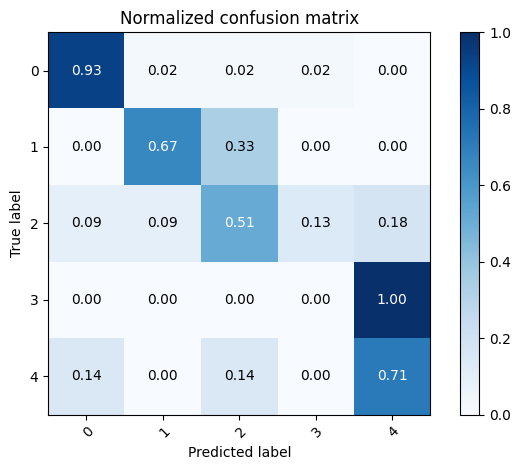

***** eval metrics *****
  eval_accuracy           =       0.71
  eval_f1                 =     0.7378
  eval_kappa              =     0.7423
  eval_loss               =      0.995
  eval_runtime            = 0:00:06.15
  eval_samples_per_second =     16.252
  eval_steps_per_second   =      4.063


In [28]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)

In [32]:
# Serialize data into file:
json.dump(metrics, open( f'../results/{pretrained_model_name}.json', 'w' ) )

In [36]:
metrics = trainer.evaluate(prepared_ds_test)
trainer.save_metrics("eval", metrics)
trainer.log_metrics("eval", metrics)

[[4679  348  135   10   31]
 [ 188  260   44    1    6]
 [ 167  188  531   90   41]
 [   6    5   46   73   25]
 [   4    1   26   11  110]]
***** eval metrics *****
  eval_accuracy           =     0.8046
  eval_f1                 =     0.8126
  eval_kappa              =     0.7629
  eval_loss               =     0.6082
  eval_runtime            = 0:04:46.89
  eval_samples_per_second =      24.49
  eval_steps_per_second   =      6.124
